[Load data](#load)

[Formulate prediction problem](#problem)

[Display permit status values](#permit_status)

[Simple classifier](#simple_classifier)

[Split according to time](#time_split)

In [1]:
# Data tools
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# ML tools
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

## Load data
<a id='load'></a>

In [2]:
data = pd.read_csv('building-permit-applications-data/Building_Permits.csv')
nrows, ncols = data.shape
print(f"Original dataset has {nrows} rows and {ncols} columns")

Original dataset has 198900 rows and 43 columns


/usr/local/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (22,32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
print("Column names:\n")
for col in data.columns:
    print(col)

Column names:

Permit Number
Permit Type
Permit Type Definition
Permit Creation Date
Block
Lot
Street Number
Street Number Suffix
Street Name
Street Suffix
Unit
Unit Suffix
Description
Current Status
Current Status Date
Filed Date
Issued Date
Completed Date
First Construction Document Date
Structural Notification
Number of Existing Stories
Number of Proposed Stories
Voluntary Soft-Story Retrofit
Fire Only Permit
Permit Expiration Date
Estimated Cost
Revised Cost
Existing Use
Existing Units
Proposed Use
Proposed Units
Plansets
TIDF Compliance
Existing Construction Type
Existing Construction Type Description
Proposed Construction Type
Proposed Construction Type Description
Site Permit
Supervisor District
Neighborhoods - Analysis Boundaries
Zipcode
Location
Record ID


## Formulate prediction problem
<a id='problem'></a>

A permit is first filed, then issued, and finally construction is completed. 

In [4]:
percent_filed    = 100*(nrows - sum((data['Filed Date']).isna()))/nrows
percent_issued   = 100*(nrows - sum((data['Issued Date']).isna()))/nrows
percent_completed = 100*(nrows - sum((data['Completed Date']).isna()))/nrows

print(f"{np.round(percent_filed, 2)}% of all permits have been filed")
print(f"{np.round(percent_issued, 2)}% of all permits have been issued")
print(f"{np.round(percent_completed, 2)}% of all permits have completed construction")

100.0% of all permits have been filed
92.49% of all permits have been issued
48.86% of all permits have completed construction


A regression problem would be to predict the time it takes for a permit to be issued since the day it was filed. 
However, the above output shows that not every permit has been issued. Simply removing unissued permits from our dataset would result in a sampling bias against them. This is significant because we can expect about 1 - 0.925 = 7.5% of all out-of-sample permits to not be issued. 

To remedy this, we can build two models that occur in sequence:
1. Classify whether or not a permit will be issued by training on both issued and unissued permit data. 
2. Predict the number of days it will take for a permit to be issued by training on permits that we know were eventually issued. 

i.e. for a new (test) permit, first classify whether or not it will eventually be issued (not based on the date it was filed). If it will be issued, then predict the number of days that will take. 

Now let's code the relevant date features as the number of days since the oldest permit date, create the labels needed for each of these tasks, and add them to our dataset. 

In [5]:
min_date = pd.to_datetime("01/01/2013") # source: Kaggle page

"""
Returns a column where each date string in `date_col` is the
number of days since January 1st, 2013. 
"""
def convert_date(date_col):
    timestamps = pd.to_datetime(date_col)
    days_since = timestamps - min_date
    return days_since.dt.days

In [6]:
data['Filed Days'] = convert_date(data['Filed Date'])
data['Issued Days'] = convert_date(data['Issued Date'])

# labels
data['Issued or not'] = 1 - (data['Issued Date']).isna() # 1 = permit was eventually issued
data['Days to issue'] = data['Issued Days'] - data['Filed Days']

Store the issued permits for our regression task in ``data_issued``. 

In [7]:
data_issued = data[(data['Issued or not'] == 1)]
nrows_issued, ncols_issued = data_issued.shape

print(f"Regression dataset has {nrows_issued} rows and {ncols_issued} columns")

Regression dataset has 183960 rows and 47 columns


## Display permit status values
<a id='permit_status'></a>

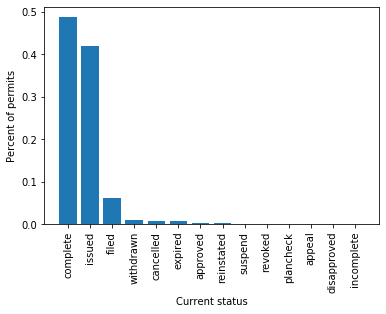

In [8]:
status_counter = Counter(data['Current Status'])
status_percent = {status:(count/nrows) for status,count in status_counter.items()}
status_percent = dict(sorted(status_percent.items(), key=lambda kv: kv[1], reverse=True))

plt.xticks(rotation='vertical')
plt.xlabel("Current status")
plt.ylabel("Percent of permits")
plt.bar(status_percent.keys(), status_percent.values());

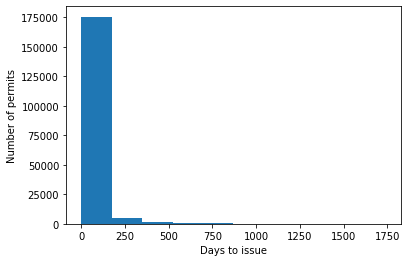

In [9]:
plt.xlabel("Days to issue")
plt.ylabel("Number of permits")
plt.hist(data_issued['Days to issue']);

In [10]:
percent_same_day = 100*sum(data_issued['Days to issue'] == 0) / nrows_issued
print(f"{np.round(percent_same_day, 2)}% of all issued permits were issued the same day they were filed")

62.78% of all issued permits were issued the same day they were filed


## Simple classifier
<a id='simple_classifier'></a>

I think the ``'Permit Type'`` feature will be particularly useful for the classification task, as small building modifications are more likely to be approved than large construction projects. Accuracy will almost certainly go up if the type is categorically encoded, but here's a quick demo to determine whether the untransformed feature is useful. 

I'll just train and test on the first 15k permits here. 
This one-feature SVM is as accurate as the constant model that predicts every permit as being issued, so the ```'Permit Type'``` feature doesn't appear to be useful on its own. 

In [11]:
n = 15000
X = np.array(data['Permit Type'][:n])
X = X.reshape(X.shape + (1,)) # convert to 2d array
y = np.array(data['Issued or not'][:n])
np.random.seed(5)
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2)

In [12]:
print("Constant model: ")
print("Training accuracy: %f" % (np.sum(y_tr)/y_tr.shape[0]))
print("Test accuracy: %f" % (np.sum(y_te)/y_te.shape[0]))

Constant model: 
Training accuracy: 0.958833
Test accuracy: 0.957000


In [13]:
print("SVM: ")
clf = SVC(gamma='auto')
clf.fit(X_tr, y_tr)

train_acc = clf.score(X_tr, y_tr) 
test_acc  = clf.score(X_te, y_te)
print(f"Training accuracy = {train_acc}")
print(f"Test accuracy     = {test_acc}")

SVM: 
Training accuracy = 0.9588333333333333
Test accuracy     = 0.957


~~## Split according to time~~
<a id='time_split'></a>

Will actually split randomly

The data goes from January 1st, 2013 to February 25th, 2018, according to the [Kaggle source](https://www.kaggle.com/aparnashastry/building-permit-applications-data). Therefore, a reasonable train-test split for the time series is for the training set to be all of 2013-2016 (inclusive), and for the test set to be all of 2017. However, we will have to decide what to do with permits that were filed in the training range but issued in the test range.

In [14]:
train_start = (pd.to_datetime("01/01/2013") - min_date).days
train_end = (pd.to_datetime("12/31/2016") - min_date).days
test_start = (pd.to_datetime("01/01/2017") - min_date).days
test_end = (pd.to_datetime("12/31/2017") - min_date).days

In [15]:
print("Number of entries that are listed as being issued before they are filed: ")
print(np.sum(data['Issued Days'] < data['Filed Days']))

Number of entries that are listed as being issued before they are filed: 
0


In [16]:
print("Number of entries filed in training period: ", end = '')
print(np.sum(data['Filed Days'].between(train_start, train_end)))
print("Number of entries issued in training period: ", end = '')
print(np.sum(data['Issued Days'].between(train_start, train_end)))
print("Proportion of entries filed in training period that are also issued in training period: ", end = '')
print(np.sum(data['Issued Days'].between(train_start, train_end))/np.sum(
    data['Filed Days'].between(train_start, train_end)))

Number of entries filed in training period: 151796
Number of entries issued in training period: 140179
Proportion of entries filed in training period that are also issued in training period: 0.9234696566444438


In [17]:
print("Number of entries filed in training period and issued in test period: ", end = '')
print(np.sum(data['Filed Days'].between(train_start, train_end) & data['Issued Days'].between(test_start, test_end)))
print("Proportion of entries filed in training period that are issued in test period: ", end = '')
print(np.sum(data['Filed Days'].between(train_start, train_end) & 
             data['Issued Days'].between(test_start, test_end))/np.sum(
             data['Filed Days'].between(train_start, train_end)))

Number of entries filed in training period and issued in test period: 3181
Proportion of entries filed in training period that are issued in test period: 0.020955756409918574


Decision: split the dataset by ```'Filed Days'```, convert all dates that are after the end of the training period to N/A

In [18]:
data_train = data.loc[data['Filed Days'].between(train_start, train_end)]
print(data_train.shape)
print("Proportion of data that is in the training set: %f" % (data_train.shape[0]/data.shape[0]))

(151796, 47)
Proportion of data that is in the training set: 0.763177


In [19]:
data_test = data.loc[data['Filed Days'].between(test_start, test_end)]
print(data_test.shape)
print("Proportion of data that is in the test set: %f" % (data_test.shape[0]/data.shape[0]))

(41151, 47)
Proportion of data that is in the test set: 0.206893


In [20]:
data_train_test = data.loc[data['Filed Days'].between(train_start, test_end)]

In [21]:
print(data_train['Issued Days'])
data_train['Issued Days'][0] = data['Issued Days'][0]
print(data_train['Issued Days'])
np.isnan(data_train['Issued Days'])

0         1042.0
1         1675.0
2            NaN
3         1659.0
4         1795.0
           ...  
197056    1864.0
197066    1864.0
197684    1876.0
198851    1879.0
198852       NaN
Name: Issued Days, Length: 151796, dtype: float64
0         1042.0
1         1675.0
2            NaN
3         1659.0
4         1795.0
           ...  
197056    1864.0
197066    1864.0
197684    1876.0
198851    1879.0
198852       NaN
Name: Issued Days, Length: 151796, dtype: float64


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


0         False
1         False
2          True
3         False
4         False
          ...  
197056    False
197066    False
197684    False
198851    False
198852     True
Name: Issued Days, Length: 151796, dtype: bool

## Train-test split

In [23]:
data_train, data_test = train_test_split(data, test_size=0.2)

In [26]:
data_train.to_csv(path_or_buf = 'data_train.csv', index = False)

In [27]:
data_test.to_csv(path_or_buf = 'data_test.csv', index = False)